In [1]:
#default_exp epscn

# EPSCN: Real-Time Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolution Neural

https://arxiv.org/abs/1609.05158

"sub-pixel convolution"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import cv2
import numpy as np
import re
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
import PIL

In [4]:
# export
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [5]:
import sys
sys.path.append('..')
from superres.datasets import *
from superres.databunch import *

In [6]:
seed = 8610
random.seed(seed)
np.random.seed(seed)

## Model

In [7]:
# https://github.com/nyk510/srcnn-pytorch

In [8]:
#export
class EPSCN(nn.Module):

    def __init__(self, upscale=2):
        super(EPSCN, self).__init__()
        self.upscale = upscale
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, upscale ** 2, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(self.upscale)

    def _initialize_weights(self):
        weights_with_relu = [
            self.conv1.weight,
            self.conv2.weight,
            self.conv3.weight
        ]

        for w in weights_with_relu:
            nn.init.orthogonal_(w, nn.init.calculate_gain('relu'))

        nn.init.orthogonal_(self.conv4.weight)

    def forward(self, x):
        h = torch.tanh(self.conv1(x))
        h = torch.tanh(self.conv2(h))
        h = torch.tanh(self.conv3(h))
        return self.pixel_shuffle(self.conv4(h))

In [9]:
test_input=torch.ones(1, 1, 64, 64)
g = EPSCN(4)
test_input = test_input.cuda()
g = g.cuda()
out = g(test_input)
print(out.size())

torch.Size([1, 1, 256, 256])


## DataBunch

In [10]:
train_hr = div2k_train_hr_crop_256

In [11]:
in_size = 64
out_size = 256
scale = 4
bs = 10

ImageDataBunch;

Train: LabelList (25245 items)
x: ImageImageList
Image (1, 64, 64),Image (1, 64, 64),Image (1, 64, 64),Image (1, 64, 64),Image (1, 64, 64)
y: ImageImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Valid: LabelList (6311 items)
x: ImageImageList
Image (1, 64, 64),Image (1, 64, 64),Image (1, 64, 64),Image (1, 64, 64),Image (1, 64, 64)
y: ImageImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Test: None


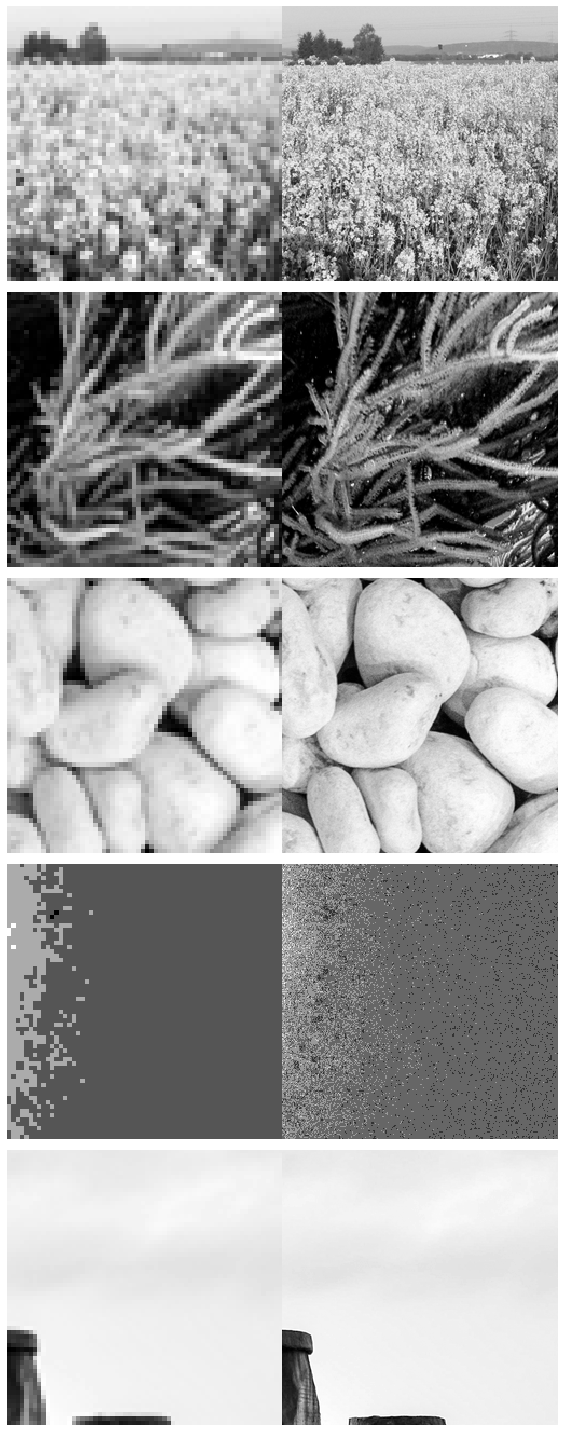

In [12]:
data = create_sr_databunch(train_hr, in_size=in_size, out_size=out_size, scale=scale, convert_mode='YCbCr', bs=bs, seed=seed)
print(data)
data.show_batch(cmap='gray')

## Training

In [13]:
model = EPSCN(upscale=4)
loss_func = MSELossFlat()
metrics = [m_psnr, m_ssim]
learn = Learner(data, model, loss_func=loss_func, metrics=metrics)
learn.path = Path('.')
model_name = model.__class__.__name__

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 2.29E-03


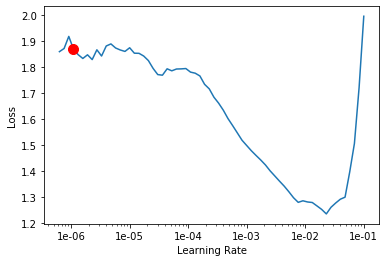

In [14]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [15]:
lr = 1e-3
lrs = slice(lr)
epoch = 3
pct_start = 0.3
wd = 1e-3
save_fname = model_name

In [16]:
callbacks = [ShowGraph(learn), SaveModelCallback(learn, name=save_fname)]

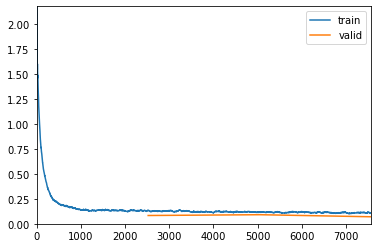

Better model found at epoch 0 with valid_loss value: 0.08296076953411102.
Better model found at epoch 2 with valid_loss value: 0.07028444111347198.


In [17]:
learn.fit_one_cycle(epoch, lrs, pct_start=pct_start, wd=wd, callbacks=callbacks)

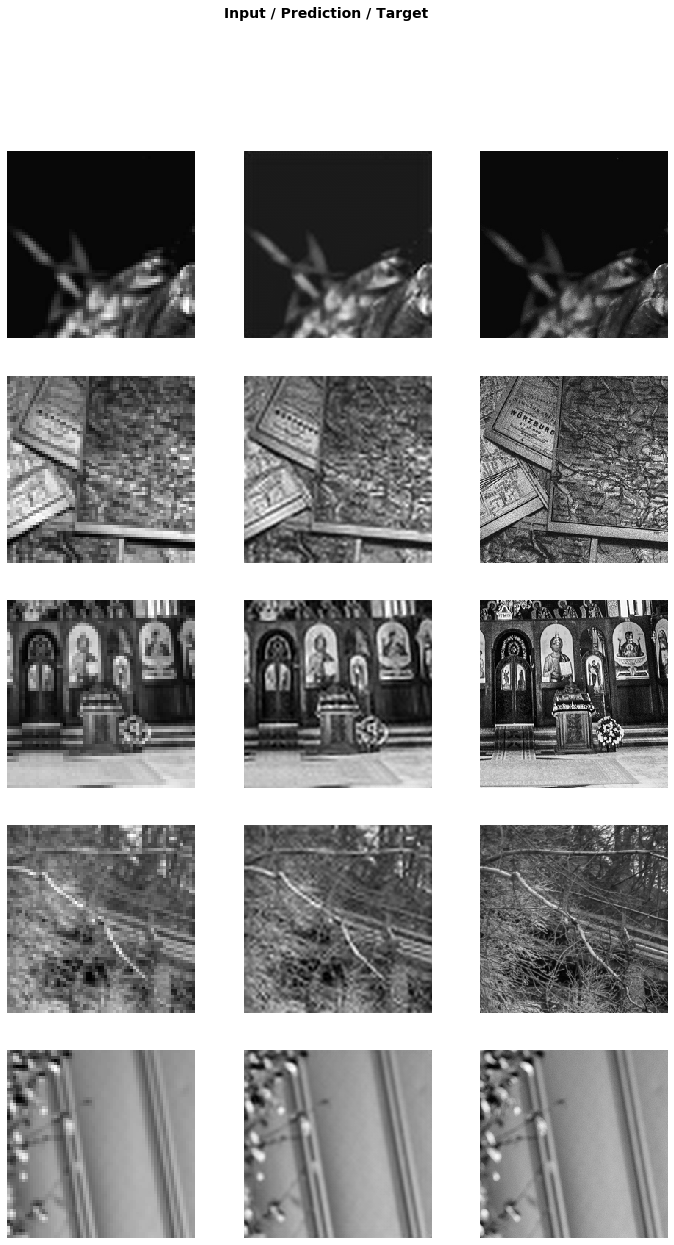

In [18]:
learn.show_results(cmap='gray')

## Test

In [19]:
test_hr = set14_hr

In [20]:
il_test_x = ImageImageList.from_folder(test_hr, convert_mode='YCbCr', after_open=partial(after_open_image, size=in_size, scale=4, luminance=True))
il_test_y = ImageImageList.from_folder(test_hr, convert_mode='YCbCr', after_open=partial(after_open_image, size=out_size, luminance=True))
il_test_x_up = ImageImageList.from_folder(test_hr, convert_mode='YCbCr', after_open=partial(after_open_image, size=out_size, scale=4, sizeup=True, luminance=True))

bicubic: PSNR:24.48,SSIM:0.7819
EPSCN:	 PSNR:23.88,SSIM:0.7717


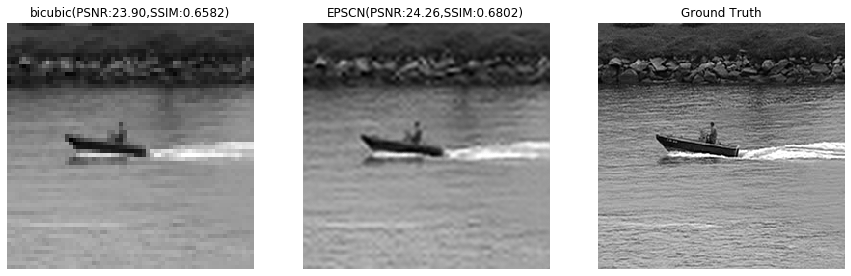

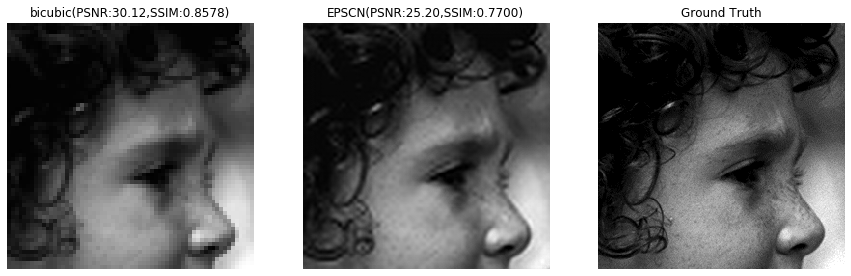

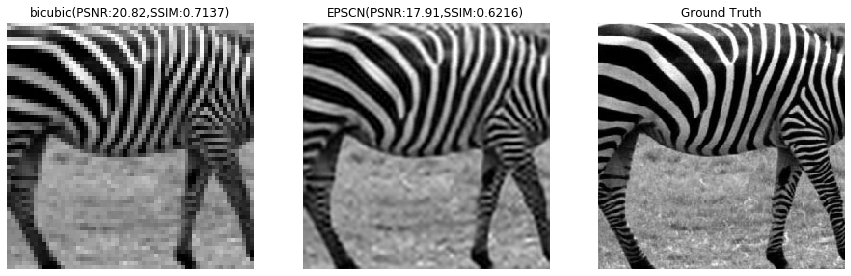

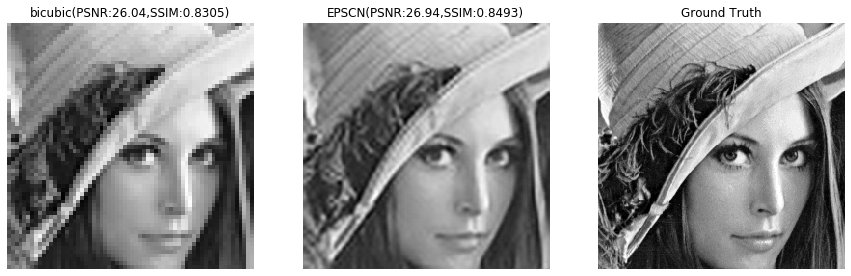

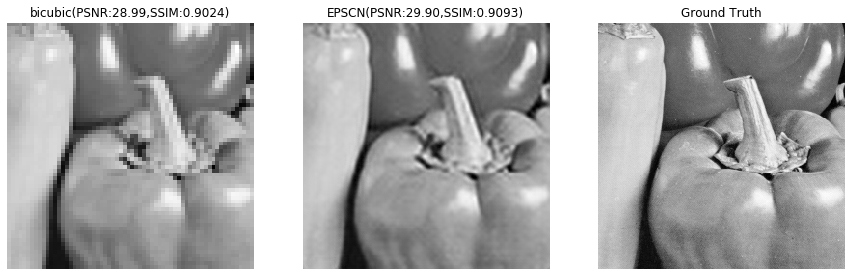

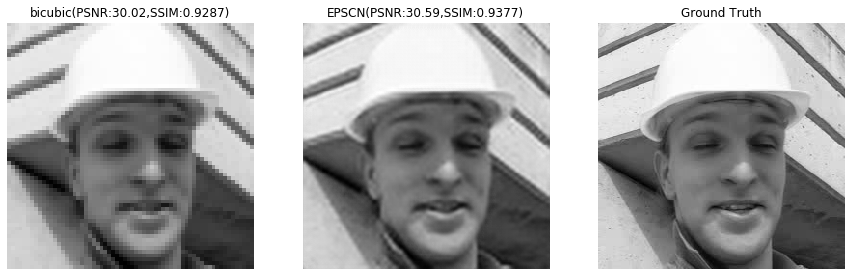

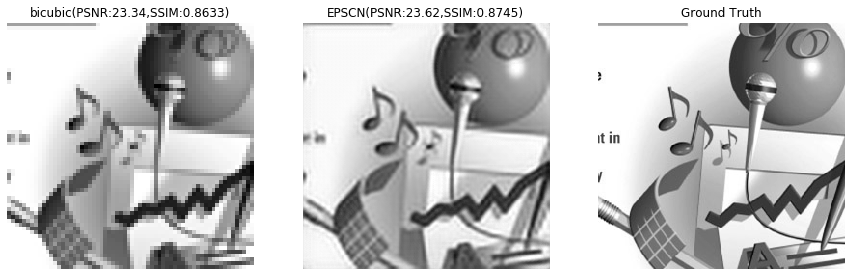

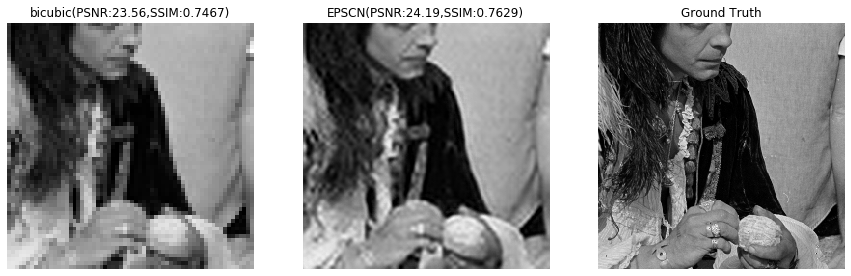

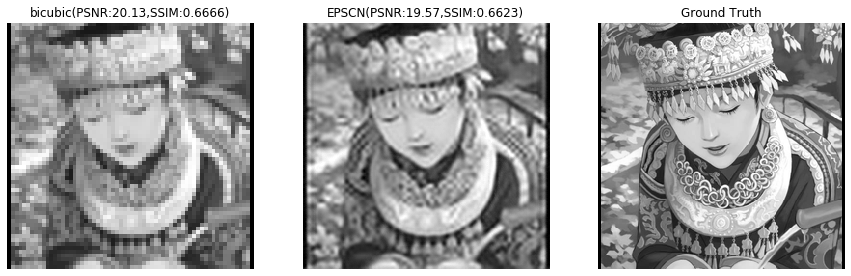

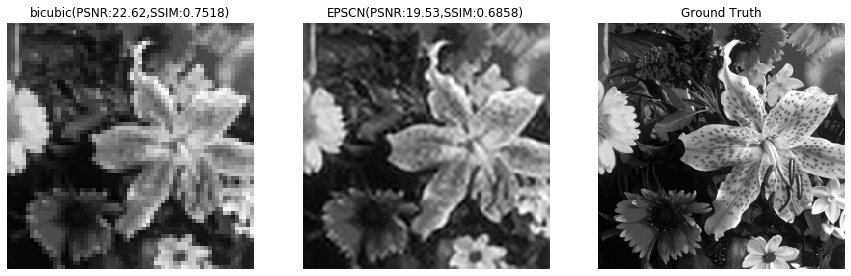

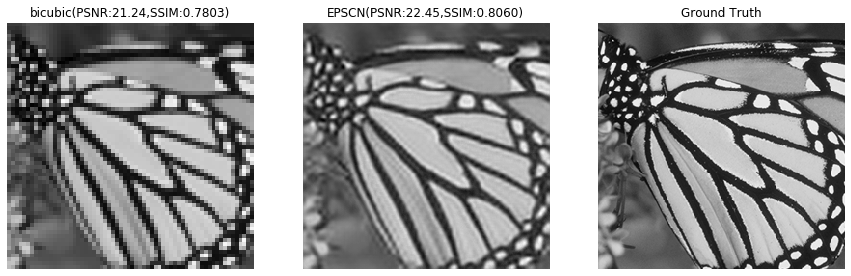

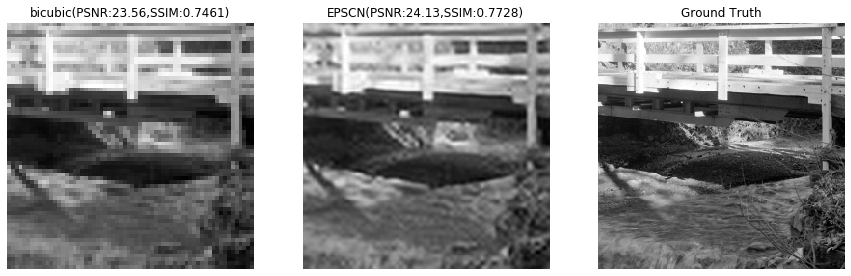

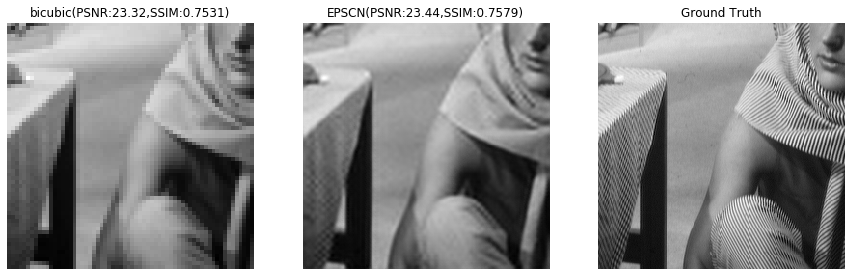

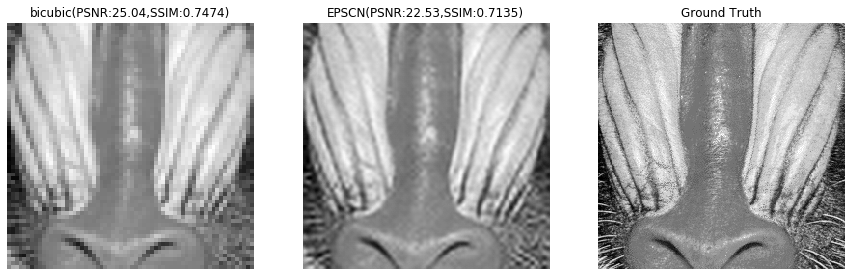

In [21]:
sr_test_upscale(learn, il_test_x, il_test_y, il_test_x_up, model_name, cmap='gray')
# Official: bicubic PSNR:25.99, SSIM:0.7486

## Report

In [22]:
model

EPSCN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=4)
)

In [23]:
learn.summary()

EPSCN
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         1,664      True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,928     True      
______________________________________________________________________
Conv2d               [32, 64, 64]         18,464     True      
______________________________________________________________________
Conv2d               [16, 64, 64]         4,624      True      
______________________________________________________________________
PixelShuffle         [1, 256, 256]        0          False     
______________________________________________________________________

Total params: 61,680
Total trainable params: 61,680
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : Flatten